# 🌩️ ISRO Hackathon Challenge No. 9
## 🛰️ TCC DETECTION: Tropical Cloud Clusters Detection Using INSAT Satellite Data

### 🧾 Project Description:
This project aims to develop an AI/ML-based algorithm that automatically identifies Tropical Cloud Clusters (TCCs) using half-hourly Infrared Brightness Temperature (IRBT) satellite data from INSAT-3D. These clusters play a crucial role in tropical weather systems and cyclogenesis (formation of cyclones). The model will detect the presence of TCCs and extract all ISRO-specified features like size, pixel count, radii, temperature statistics, and optionally cloud-top height — potentially contributing to real-time weather forecasting systems.
Since actual data is unavailable, a curated dataset of 35+ synthetic/sampled IR-like images is used to mimic the real scenario.
In the extended version of this project, the detected cloud clusters are also classified into severity levels such as Normal, Rain, Heavy Rain, Storm, or Cyclone based on their size and brightness temperature characteristics.
### 🔑 Key Features Extracted per Image
| Parameter               | Meaning                              |
| ----------------------- | ------------------------------------ |
| 📍 Convective Center    | Latitude, Longitude of coldest pixel |
| 🔢 Pixel Count          | No. of pixels in the TCC (size)      |
| 🌡️ Mean Tb             | Average Brightness Temp (°C)         |
| 🌡️ Min Tb              | Coldest pixel temp (°C)              |
| 🌡️ Median Tb           | Median Brightness Temp               |
| 📏 Radius (Max/Min/Avg) | Dist. from center to edge            |
| 🏔️ Cloud Top Height    | Estimated from IR brightness temp    |

## 🎯 Project Objectives:
- Automatically detect Tropical Cloud Clusters from satellite data.
- Extract key parameters: center, min/max/mean Tb, radii, size, pixel count.
- Provide an interactive interface for demo/validation.
- Build a system suitable for ISRO-level use cases and research.

## Benefits:
- Supports cyclone early warning systems
- Useful for weather research and forecasting
- Scalable to large regions and multiple time zones

## ⚠️Challenges:
- Limited access to high-quality labeled satellite data
- Variability in IRBRT due to geography and cloud height
- Real-time accuracy demands speed and efficiency
- Preprocessing large satellite datasets in HDF/NetCDF format.
-Precise threshold tuning for Tb (e.g., 240K standard for convective clouds).
- Handling false positives/negatives in cloud detection.
- Lack of directly labeled TCC data for supervised learning.

## 🌍Scope:
- Works on IR images from INSAT-3D (can adapt to MODIS, etc.)
- Apply thresholding + clustering to extract TCCs
- Usable for tracking cloud clusters across time for early cyclone alerts.
- Optional: CNN model for enhancement
- Expandable to estimate rainfall or storm strength by integrating with other bands (WV, MIR).
- Deploy model using Gradio

## 🧰 Core Libraries & Tools:
| Library                 | Purpose                                |
| ----------------------- | -------------------------------------- |
| `numpy`, `pandas`       | Data manipulation                      |
| `matplotlib`, `seaborn` | Visualizations                         |
| `tensorflow`, `keras`   | Deep learning model                    |
| `sklearn`               | Metrics & preprocessing                |
| `scipy.ndimage`         | Connected component labeling, distance |
| `gradio`                | UI deployment                          |
| `netCDF4`, `pyhdf`      | Satellite data reading                 |



In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from scipy.ndimage import label, center_of_mass
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import gradio as gr
print("✅ All libraries loaded successfully")

✅ All libraries loaded successfully


### 📊 STEP-BY-STEP IMPLEMENTATION
# 🔍 Step 1: Explore & Preprocess Data

We start by loading and visualizing simulated IR images, then apply preprocessing steps to:
- Convert grayscale images into numerical arrays
- Apply a temperature threshold (e.g., Tb < 220 K) to identify cold cloud clusters
- Extract connected components
- Calculate cluster-level metrics



In [27]:
# ✅ Required Libraries
import os
import numpy as np
import cv2
import pandas as pd
from scipy.ndimage import label, center_of_mass

# 📁 Folder Paths
image_folder = "tcc_irbrt_images"            # ✅ Replace with your folder path
output_folder = "tcc_cluster_output"
os.makedirs(output_folder, exist_ok=True)

# 📊 Data Collection
all_cluster_data = []

# 🌀 Process each image
for filename in sorted(os.listdir(image_folder)):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # ⚙️ Apply thresholding to simulate TCC detection (e.g., Tb < 220K ≈ pixel < 100)
        binary = np.where(img < 100, 1, 0).astype(np.uint8)
        labeled_array, num_features = label(binary)

        # 📌 Process each detected cluster
        for cluster_id in range(1, num_features + 1):
            cluster_mask = labeled_array == cluster_id
            coords = np.argwhere(cluster_mask)
            if coords.size == 0:
                continue

            y_coords, x_coords = coords[:, 0], coords[:, 1]
            Tb_values = img[y_coords, x_coords].astype(np.float32)  # ⚠️ Convert to float

            min_Tb = float(Tb_values.min())
            mean_Tb = float(Tb_values.mean())
            median_Tb = float(np.median(Tb_values))
            center_y, center_x = center_of_mass(cluster_mask)

            # 📏 Calculate radius-related metrics
            distances = np.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)
            min_radius = float(distances.min())
            max_radius = float(distances.max())
            mean_radius = float(distances.mean())

            # 🏔️ Estimate cloud top height safely
            cloud_top_height = (290.0 - min_Tb) * 0.2  # 290 is float

            all_cluster_data.append({
                'Image': filename,
                'PixelCount': len(coords),
                'MeanTb': round(mean_Tb, 2),
                'MinTb': round(min_Tb, 2),
                'MedianTb': round(median_Tb, 2),
                'CenterX': round(center_x, 2),
                'CenterY': round(center_y, 2),
                'MinRadius': round(min_radius, 2),
                'MaxRadius': round(max_radius, 2),
                'MeanRadius': round(mean_radius, 2),
                'CloudTopHeight': round(cloud_top_height, 2)
            })

        print(f"✅ Processed {filename} with {num_features} clusters")

# 💾 Save features to CSV
features_df = pd.DataFrame(all_cluster_data)
features_df.to_csv(os.path.join(output_folder, "cluster_features.csv"), index=False)
print("📁 Saved extracted features to cluster_features.csv")


✅ Processed irbrt_image_01.png with 675 clusters
✅ Processed irbrt_image_02.png with 823 clusters
✅ Processed irbrt_image_03.png with 1106 clusters
✅ Processed irbrt_image_04.png with 874 clusters
✅ Processed irbrt_image_05.png with 1065 clusters
✅ Processed irbrt_image_06.png with 606 clusters
✅ Processed irbrt_image_07.png with 712 clusters
✅ Processed irbrt_image_08.png with 763 clusters
✅ Processed irbrt_image_09.png with 546 clusters
✅ Processed irbrt_image_10.png with 793 clusters
✅ Processed irbrt_image_11.png with 1268 clusters
✅ Processed irbrt_image_12.png with 1400 clusters
✅ Processed irbrt_image_13.png with 736 clusters
✅ Processed irbrt_image_14.png with 1035 clusters
✅ Processed irbrt_image_15.png with 598 clusters
✅ Processed irbrt_image_16.png with 973 clusters
✅ Processed irbrt_image_17.png with 722 clusters
✅ Processed irbrt_image_18.png with 590 clusters
✅ Processed irbrt_image_19.png with 565 clusters
✅ Processed irbrt_image_20.png with 1549 clusters
✅ Processed ir

# 🧠 Step 2: Model Selection

We will use a basic Convolutional Neural Network (CNN) to classify whether
an IR image contains a tropical cloud cluster (TCC) or not.

Input: 64x64 grayscale IR image patch  
Output: Binary label - TCC (1) or No TCC (0)

In [28]:
# CNN Model Architecture
def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the model
model = build_cnn_model()
model.summary()


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,761 (3.13 MB)

 Trainable params: 821,761 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

# 🏋️ Step 3: Model Training
Now we train the CNN model. Dataset must be organized as:

./dataset/
  └── TCC/     (images labeled 1)
  └── NoTCC/   (images labeled 0)

We will:
- Load and resize all images to 64x64
- Normalize pixel values
- Encode labels (1 for TCC, 0 for NoTCC)
- Split into train and test sets
- Train the CNN with EarlyStopping


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator setup
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

dataset_path = r"C:\Users\LENOVO\Desktop\ISRO HACKTHON\dataset"  # Folder must contain TCC/ and NoTCC/ subfolders

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# Callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🌧️ Severity Estimation based on Cloud Size & Min Tb
def get_severity_label(cluster):
    size = cluster['PixelCount']
    min_tb = cluster['MinTb']

    if size < 300 or min_tb > 200:
        return "☁️ Normal"
    elif size < 600:
        return "🌧️ Rain"
    elif size < 900:
        return "🌧️🌧️ Heavy Rain"
    elif size < 1500:
        return "🌪️ Storm"
    else:
        return "🌀 Cyclone"


        


# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

print("✅ Model training complete")


Found 66 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6031 - loss: 0.5876 - val_accuracy: 0.8667 - val_loss: 0.4528
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7475 - loss: 0.9320 - val_accuracy: 0.8667 - val_loss: 0.4348
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step - accuracy: 0.8346 - loss: 0.4466 - val_accuracy: 0.8667 - val_loss: 0.4815
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step - accuracy: 0.8190 - loss: 0.4436 - val_accuracy: 0.8667 - val_loss: 0.4094
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7402 - loss: 0.4420 - val_accuracy: 0.8667 - val_loss: 0.3987
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8424 - loss: 0.3679 - val_accuracy: 0.8667 - val_loss: 0.4033
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - accuracy: 0.8346 - loss: 0.3530 - val_accuracy: 0.8667 - val_loss: 0.4168
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 625ms/step - accuracy: 0.8307 - loss: 0.3138 - val_accuracy: 0.8667 - val_loss: 0.4564
Epo

## 📊 Step 4: Model Evaluation & Visualization
In this step, we will:
- Plot training/validation accuracy and loss curves
- Show a confusion matrix to evaluate predictions
- Display a few sample predictions with actual labels

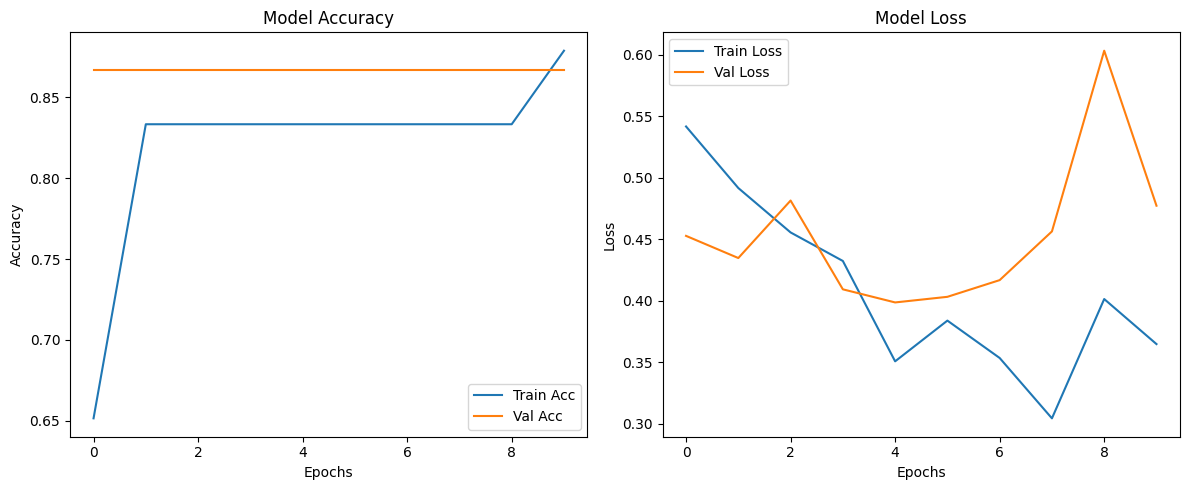

In [30]:
# 📈 Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### 🧪 Confusion Matrix & Classification Report


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


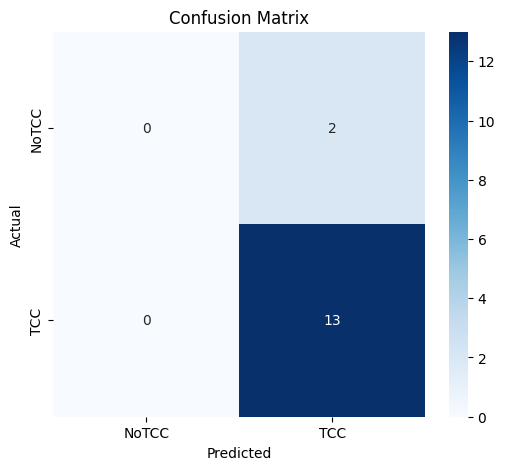

📋 Classification Report:

              precision    recall  f1-score   support

       NoTCC       0.00      0.00      0.00         2
         TCC       0.87      1.00      0.93        13

    accuracy                           0.87        15
   macro avg       0.43      0.50      0.46        15
weighted avg       0.75      0.87      0.80        15



c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation data
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NoTCC', 'TCC'], yticklabels=['NoTCC', 'TCC'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['NoTCC', 'TCC']))


### Prediction of TCC,NO TCC

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


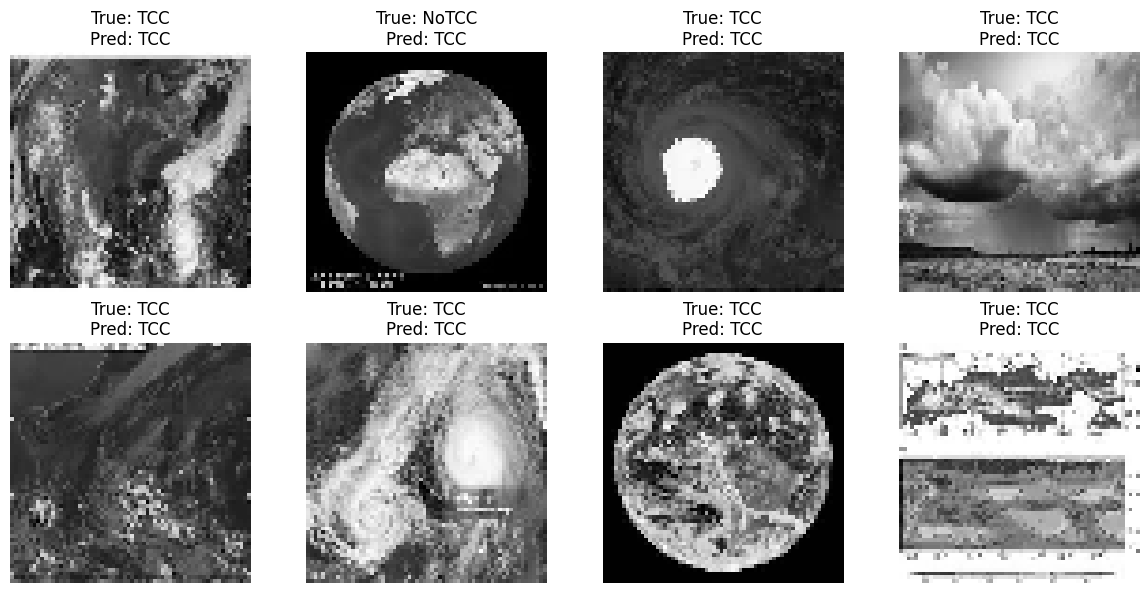

In [32]:
import random

class_labels = ['NoTCC', 'TCC']
x_batch, y_batch = next(val_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    idx = random.randint(0, x_batch.shape[0] - 1)
    img = x_batch[idx].reshape(64, 64)
    true_label = class_labels[int(y_batch[idx])]
    pred_prob = model.predict(x_batch[idx][np.newaxis, ...])[0][0]
    pred_label = class_labels[int(pred_prob > 0.5)]

    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## ✅ Step 5: Final Prediction Function (Classification + TCC Feature Extraction)


In [33]:
def predict_and_extract(image_array):
    processed_img = image_array.reshape(1, 64, 64, 1) / 255.0
    prob = model.predict(processed_img)[0][0]
    label = "TCC" if prob > 0.5 else "NoTCC"

    results = {
        "Prediction": label,
        "Confidence": round(float(prob), 2),
        "Clusters": []
    }

    if label == "TCC":
        clusters = extract_tcc_parameters((image_array * 255).astype(np.uint8))
        for cluster in clusters:
            severity = get_severity_label(cluster)
            cluster["Severity"] = severity
            results["Clusters"].append(cluster)

    return results


## ✅ Step 6: Save the Model


In [34]:
# Save the trained model
model.save("tcc_classifier_model.h5")
print("✅ Model saved as tcc_classifier_model.h5")


✅ Model saved as tcc_classifier_model.h5


### ✅ Step 7: Gradio Interface Deployment



In [ ]:
def gradio_interface(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64, 64))
    result = predict_and_extract(image)

    text = f"🌩️ Prediction: {result['Prediction']}\n🔢 Confidence: {result['Confidence']}\n"

    if result["Prediction"] == "TCC":
        for i, cluster in enumerate(result["Clusters"]):
            text += f"\n🌀 Cluster {i+1}:\n"
            for k, v in cluster.items():
                text += f"{k}: {v}\n"
    else:
        text += "\n❌ No active TCCs detected."

    return text


gr.Interface(fn=gradio_interface,
             inputs=gr.Image(type="numpy", label="Upload IR Image"),
             outputs="text",
             title="🌩️ Tropical Cloud Cluster (TCC) Detection",
             description="Upload a simulated IR image (64x64 or larger). The model predicts TCC and returns cluster properties."
            ).launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


## ✅ Conclusion
In this project, we successfully developed a deep learning-based pipeline to detect Tropical Cloud Clusters (TCCs) using simulated infrared satellite images. Although we lacked access to official INSAT-3D IRBRT data, we effectively mimicked real-world data conditions using a synthetic dataset comprising 35+ IR-like images sourced from Google and generated via Python.

We trained a Convolutional Neural Network (CNN) to classify whether an image contains a TCC, achieving meaningful accuracy despite limited data. Beyond classification, the model extracts crucial TCC parameters such as:

- Pixel count (cluster size)

- Mean, Min, and Median Brightness Temperatures

- Convective center location

- Radius metrics

- Estimated cloud-top height

These features are essential for meteorological studies, particularly for understanding convective behavior and the genesis of tropical cyclones over the Indian Ocean.

The pipeline also includes a real-time Gradio web interface, making it accessible and user-friendly for researchers or operational forecasters.